In [1]:
#Importing the relevant libraries for doing the analysis (there are probably still too many that you do not need)
import pandas as pd
from pyFlowSOM import map_data_to_nodes, som
import seaborn as sns 
import numpy as np
import scanpy as sc
import squidpy as sq
import os
import gc
import random
from matplotlib import rcParams
import matplotlib.pyplot as plt
from pathlib import Path
from skimage.io  import imread, imsave
import skimage.io
import anndata as ad
import seaborn as sns 
from scipy import stats
import warnings
import shutil
import math
import openpyxl

/opt/anaconda3/envs/pre-processing/lib/python3.9/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/opt/anaconda3/envs/pre-processing/lib/python3.9/site-packages/spatialdata/__init__.py:9: UserWarning: Geopandas was set to use PyGEOS, changing to shapely 2.0 with:

	geopandas.options.use_pygeos = True

If you intended to use PyGEOS, set the option to False.
  _check_geopandas_using_shapely()


In [2]:
# Read the cell size normalized table
df = pd.read_csv('/Volumes/VERBATIM HD 1/Hamburg Project/preprocessing_figures/cell_table_transformed.csv', index_col=0)

In [3]:
df

,SMA,CA9,nuclei,CD98,CytC,CD4,MSH2,FoxP3,MCT1,PDL1,...,centroid-0,centroid-1,eccentricity,perimeter,convex_area,area,axis_major_length,axis_minor_length,label,fov
0,0.000134,0.021289,0.046148,0.006393,0.015713,0.008352,0.024734,0.023453,0.000193,0.009023,...,11.410959,5.593607,0.772695,58.384776,237.0,219.0,21.380209,13.571676,1,A1a
1,0.002969,0.014578,0.034238,0.008831,0.106513,0.001745,0.063474,0.001185,0.002774,0.004173,...,5.158590,29.418502,0.845467,62.041631,241.0,227.0,23.904973,12.765919,2,A1a
2,0.000012,0.113299,0.064198,0.034138,0.011429,0.000073,0.066563,0.000000,0.001506,0.009498,...,4.698324,47.871508,0.796219,52.485281,186.0,179.0,19.813871,11.987551,3,A1a
3,0.000004,0.128277,0.097153,0.040913,0.030368,0.000812,0.016016,0.001458,0.005280,0.022267,...,4.387283,64.393064,0.862564,54.727922,185.0,173.0,21.773657,11.016341,4,A1a
4,0.000126,0.107682,0.054147,0.070130,0.098551,0.002679,0.081037,0.001234,0.020924,0.004454,...,16.364760,75.551777,0.741402,107.219300,742.0,647.0,35.806907,24.028635,5,A1a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
579942,0.000000,0.025945,0.044181,0.021980,0.034234,0.041525,0.004055,0.009135,0.007513,0.094103,...,1017.720930,788.562791,0.736793,55.798990,225.0,215.0,20.467027,13.838134,1341,E4e
579943,0.000000,0.052626,0.187155,0.222263,0.000000,0.026241,0.000000,0.003578,0.026086,0.083621,...,1018.845238,89.535714,0.835885,49.313708,171.0,168.0,20.011559,10.984429,1342,E4e
579944,0.000000,0.063988,0.164008,0.131201,0.082124,0.007325,0.002103,0.011567,0.010024,0.013886,...,1019.349315,399.575342,0.840165,48.177670,151.0,146.0,19.110780,10.364355,1343,E4e
579945,0.000000,0.037612,0.188549,0.035632,0.035699,0.096411,0.041807,0.016846,0.029209,0.117594,...,1018.881356,482.114407,0.923320,64.142136,243.0,236.0,28.365967,10.893396,1344,E4e


In [4]:
# Getting the names of the columns in order to define the relevant channels
df.columns

Index(['SMA', 'CA9', 'nuclei', 'CD98', 'CytC', 'CD4', 'MSH2', 'FoxP3', 'MCT1',
       'PDL1', 'CD31', 'PD1', 'ASCT2', 'CD7', 'LDH', 'CD163', 'STING1', 'DCN',
       'CD68', 'GS', 'CD8', 'CD3e', 'GLS', 'MPO', 'ATP5A', 'CS', 'CD20',
       'PKM2', 'GLUT1', 'HLADRa', 'CD14', 'CD45', 'PanCK', 'MSH6', 'ARG1',
       'CPT1A', 'Vimentin', 'Ki67', 'membrane', 'centroid-0', 'centroid-1',
       'eccentricity', 'perimeter', 'convex_area', 'area', 'axis_major_length',
       'axis_minor_length', 'label', 'fov'],
      dtype='object')

In [5]:
# Extract the relevant columns for the first comparison
columns_to_compare = ['SMA', 'CD31', 'CD163', 'CD68', 'CD8', 'CD45',
       'PanCK', 'MPO', 'CD7']

# Create a new column to store the result of the comparison
df['highest_value_column'] = df[columns_to_compare].idxmax(axis=1)

# Display the updated dataframe
print(df)


             SMA       CA9    nuclei      CD98      CytC       CD4      MSH2  \
0       0.000134  0.021289  0.046148  0.006393  0.015713  0.008352  0.024734   
1       0.002969  0.014578  0.034238  0.008831  0.106513  0.001745  0.063474   
2       0.000012  0.113299  0.064198  0.034138  0.011429  0.000073  0.066563   
3       0.000004  0.128277  0.097153  0.040913  0.030368  0.000812  0.016016   
4       0.000126  0.107682  0.054147  0.070130  0.098551  0.002679  0.081037   
...          ...       ...       ...       ...       ...       ...       ...   
579942  0.000000  0.025945  0.044181  0.021980  0.034234  0.041525  0.004055   
579943  0.000000  0.052626  0.187155  0.222263  0.000000  0.026241  0.000000   
579944  0.000000  0.063988  0.164008  0.131201  0.082124  0.007325  0.002103   
579945  0.000000  0.037612  0.188549  0.035632  0.035699  0.096411  0.041807   
579946  0.000000  0.068821  0.017571  0.354710  0.083370  0.028738  0.002350   

           FoxP3      MCT1      PDL1  .

In [6]:
# Specify the columns for second comparison using the highest_value_column to filter for certain rows
columns_to_compare = ["CD3e", "CD8", 'CD7', "CD14", "MPO",'CD20', 'CD68', "CD163", "HLADRa"]

# Check if "highest_value_column" is "CD45", if yes, compare the specified columns
mask_cd45 = df['highest_value_column'] == 'CD45'
df.loc[mask_cd45, 'highest_value_column_2'] = df.loc[mask_cd45, columns_to_compare].idxmax(axis=1)

# For rows not labeled CD45, copy the existing label from "highest_value_column" to the new column
df.loc[~mask_cd45, 'highest_value_column_2'] = df.loc[~mask_cd45, 'highest_value_column']

# Display the updated dataframe
print(df)


             SMA       CA9    nuclei      CD98      CytC       CD4      MSH2  \
0       0.000134  0.021289  0.046148  0.006393  0.015713  0.008352  0.024734   
1       0.002969  0.014578  0.034238  0.008831  0.106513  0.001745  0.063474   
2       0.000012  0.113299  0.064198  0.034138  0.011429  0.000073  0.066563   
3       0.000004  0.128277  0.097153  0.040913  0.030368  0.000812  0.016016   
4       0.000126  0.107682  0.054147  0.070130  0.098551  0.002679  0.081037   
...          ...       ...       ...       ...       ...       ...       ...   
579942  0.000000  0.025945  0.044181  0.021980  0.034234  0.041525  0.004055   
579943  0.000000  0.052626  0.187155  0.222263  0.000000  0.026241  0.000000   
579944  0.000000  0.063988  0.164008  0.131201  0.082124  0.007325  0.002103   
579945  0.000000  0.037612  0.188549  0.035632  0.035699  0.096411  0.041807   
579946  0.000000  0.068821  0.017571  0.354710  0.083370  0.028738  0.002350   

           FoxP3      MCT1      PDL1  .

In [14]:
# Specify the columns for second comparison using the new_column to filter for certain rows
columns_to_compare = ["CD4", "CD8", 'CD7']

# Check if "highest_value_column" is "CD45", if yes, compare the specified columns
mask_cd45 = df['highest_value_column_2'] == 'CD3e'
df.loc[mask_cd45, 'highest_value_column_3'] = df.loc[mask_cd45, columns_to_compare].idxmax(axis=1)

# For rows not labeled CD45, copy the existing label from "highest_value_column" to the new column
df.loc[~mask_cd45, 'highest_value_column_3'] = df.loc[~mask_cd45, 'highest_value_column_2']

# Display the updated dataframe
print(df)


             SMA       CA9    nuclei      CD98      CytC       CD4      MSH2  \
0       0.000134  0.021289  0.046148  0.006393  0.015713  0.008352  0.024734   
1       0.002969  0.014578  0.034238  0.008831  0.106513  0.001745  0.063474   
2       0.000012  0.113299  0.064198  0.034138  0.011429  0.000073  0.066563   
3       0.000004  0.128277  0.097153  0.040913  0.030368  0.000812  0.016016   
4       0.000126  0.107682  0.054147  0.070130  0.098551  0.002679  0.081037   
...          ...       ...       ...       ...       ...       ...       ...   
579942  0.000000  0.025945  0.044181  0.021980  0.034234  0.041525  0.004055   
579943  0.000000  0.052626  0.187155  0.222263  0.000000  0.026241  0.000000   
579944  0.000000  0.063988  0.164008  0.131201  0.082124  0.007325  0.002103   
579945  0.000000  0.037612  0.188549  0.035632  0.035699  0.096411  0.041807   
579946  0.000000  0.068821  0.017571  0.354710  0.083370  0.028738  0.002350   

           FoxP3      MCT1      PDL1  .

In [15]:
# Select rows you need for the mantis viewer
selected_columns = df[["fov", "label", "highest_value_column_3"]]

In [16]:
selected_columns

,fov,label,highest_value_column_3
0,A1a,1,PanCK
1,A1a,2,CD7
2,A1a,3,CD7
3,A1a,4,PanCK
4,A1a,5,PanCK
...,...,...,...
579942,E4e,1341,PanCK
579943,E4e,1342,CD14
579944,E4e,1343,CD68
579945,E4e,1344,PanCK


In [17]:
# Save the new DataFrame to a CSV file without a header so that i can be loaded in mantis viewer
selected_columns.to_csv(('/Volumes/VERBATIM HD 1/Hamburg Project/preprocessing_figures/annotation_mantis/annotation_hierarchical.csv'), header=False, index=False)

In [18]:
df.to_csv('/Volumes/VERBATIM HD 1/Hamburg Project/preprocessing_figures/cell_table_with_annotation_TG/cell_table_with_annotation_1.csv')

/opt/anaconda3/envs/pre-processing/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/envs/pre-processing/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/envs/pre-processing/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/envs/pre-processing/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future v

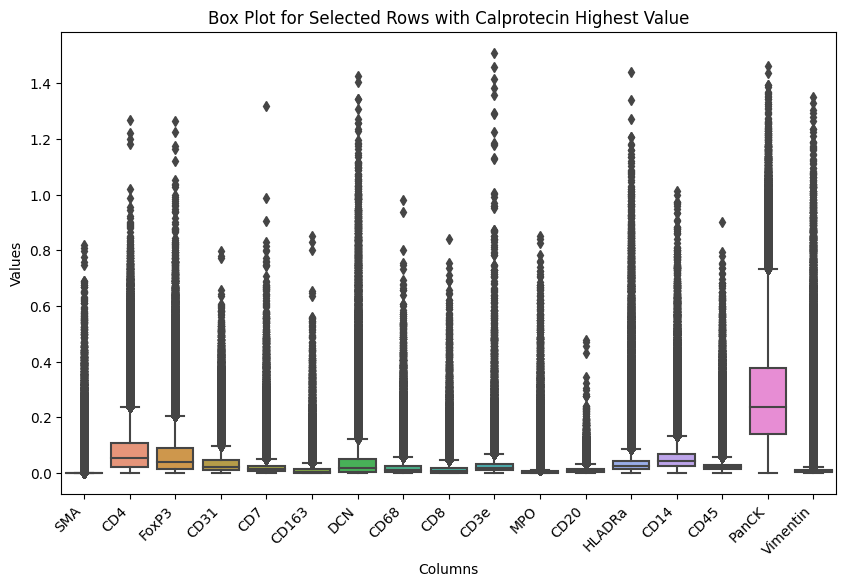

In [12]:
# Boxplot visualisation
# Select rows where "CD45" had the highest value in the new column
Calprotectin_rows = df[df['highest_value_column_3'] == 'PanCK']

# Specify the columns for the box plot
columns_for_boxplot = ['SMA','CD4','FoxP3','CD31','CD7', 'CD163', 'DCN',
       'CD68','CD8', 'CD3e', 'MPO', 'CD20', 'HLADRa', 'CD14', 'CD45', 'PanCK', 'Vimentin']  # Replace with your actual column names

# Create a box plot using seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(data=Calprotectin_rows[columns_for_boxplot])
plt.title("Box Plot for Selected Rows with Calprotecin Highest Value")
plt.xlabel("Columns")
plt.ylabel("Values")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

plt.show()


In [20]:
# Heatmap visualisation
# Specify the columns for the heatmap
columns_for_heatmap = ['SMA','CD4','FoxP3','CD31','CD7', 'CD163', 'DCN',
       'CD68','CD8', 'CD3e', 'MPO', 'CD20', 'HLADRa', 'CD14', 'CD45', 'PanCK', 'Vimentin', 'Fe'] # Replace with your actual column names

# Create a pivot table to prepare data for the heatmap
heatmap_data = df.pivot_table(index='highest_value_column_3', values=columns_for_heatmap)

# Create a heatmap using seaborn
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, cmap="YlGnBu", annot=True, fmt=".2f", linewidths=.5)
plt.title("Heatmap for Categories from new_column_2")
plt.xlabel("Columns")
plt.ylabel("Categories")
plt.show()


KeyError: 'Fe'